In [2]:
!pip install umap

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3550 sha256=fd45788586b248cb33b59e49e433e0db5bb4e8522177b4e70e0be79a82b07813
  Stored in directory: c:\users\lenovo\appdata\local\pip\cache\wheels\48\4a\1c\1d511cbb0413a448d8546e958f8e82b98d9bb493038d19ece2
Successfully built umap


In [109]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.metrics import classification_report

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Loading the dataset

In [45]:
df=pd.read_csv('../datasets/dish_type_results_25758.csv')

In [46]:
df.shape

(25758, 21)

In [47]:
# Extract all numbers (including decimals) into lists
df['numbers'] = df['dish_type_response'].str.findall(r'\d+(?:\.\d+)?')

In [48]:
df['len_numbers']=df['numbers'].apply(len)

In [49]:
df.groupby('len_numbers').size()

len_numbers
0      642
1    20525
2     4486
3       90
4        9
5        5
6        1
dtype: int64

In [50]:
# Replace empty lists with [-1]
df['numbers'] = df['numbers'].apply(lambda x: [-1] if len(x) == 0 else x)

In [51]:
df[df['len_numbers']==0].head(2)

,title,ingredients,directions,link,source,NER,NER_list,NER_len,directions_len,title_lower,...,verbs,lemmed_verbs,filtered_verbs,set_verbs,clean_direction,pairs,pairs_set,dish_type_response,numbers,len_numbers
10,""" Pancake Mini Muffins. ""","[""3 cup all-purpose flour"", ""1 tbsp baking pow...","[""Preheat oven to 425 degrees ."", ""For a softe...",cookpad.com/us/recipes/362436-pancake-mini-muf...,Recipes1M,"[""all-purpose"", ""baking powder"", ""salt"", ""milk...",['all-purpose' 'baking powder' 'salt' 'milk' '...,9,598,""" pancake mini muffins. """,...,['degrees' 'sift' 'set' 'set' 'whisk' 'combine...,['degrees' 'sift' 'set' 'set' 'whisk' 'combine...,['degrees' 'sift' 'set' 'set' 'whisk' 'combine...,['sit' 'sift' 'melt' 'degrees' 'combine' 'whis...,preheat oven degrees softer muffin bake degree...,['stir milk' 'whisk eggs' 'whisk vanilla' 'com...,['use blueberries' 'whisk eggs' 'serve syrup' ...,"RATIONALE: Pancakes, Mini, Muffins, All-purpos...",[-1],0
51,"""Food For The Gods""","[""1 cup white sugar"", ""1/3 cup graham cracker ...","[""Preheat oven to 250\u00b0. Mix all ingredien...",www.cookbooks.com/Recipe-Details.aspx?id=31289,Gathered,"[""white sugar"", ""graham cracker crumbs"", ""baki...",['white sugar' 'graham cracker crumbs' 'baking...,7,308,"""food for the gods""",...,['whipping' 'greased' 'baking' 'cool' 'add' 'w...,['whip' 'grease' 'bake' 'cool' 'add' 'whip' 'a...,['whip' 'grease' 'bake' 'cool' 'add' 'whip' 'a...,['bake' 'add' 'cool' 'grease' 'whip'],preheat oven mix ingredients except whipping c...,['whip cream' 'whip cream' 'whip cream'],['whip cream'],RATIONALE: Dates and walnuts are common ingred...,[-1],0


In [52]:
df['len_numbers']=df['numbers'].apply(len)
df.groupby('len_numbers').size()

len_numbers
1    21167
2     4486
3       90
4        9
5        5
6        1
dtype: int64

In [53]:
# De-duplicated numbers
df['numbers_dedup'] = df['numbers'].apply(
    lambda x: [x[0]] if len(x) > 1 and all(i == x[0] for i in x) else x
)

In [54]:
df['num_ded_len']=df['numbers_dedup'].apply(len)

In [55]:
df['number_after_equals'] = df['dish_type_response'].str.extract(r'NUMBER\s*=\s*(\d+(?:\.\d+)?)')

# Now, apply the condition: only keep the extracted number if num_ded_len > 1, else set to NaN
df['number_after_equals'] = np.where(
    df['number_after_equals'].isna(),
    df['numbers_dedup'],
    df['number_after_equals']
)

In [56]:
df['number_after_equals'].value_counts()

number_after_equals
2                     5238
5                     4144
4                     4050
7                     3772
1                     3703
3                     1838
6                     1809
[-1]                   642
0                      345
[7]                     55
[1]                     44
[5]                     33
[4]                     25
[2]                     15
[0]                     11
[6]                      9
[3]                      7
[3, 10]                  2
[6, 4]                   2
6.5                      1
[3, 5, 7]                1
[1, 7]                   1
7.1                      1
[1, 2, 3]                1
[1, 4]                   1
[3, 0, 1]                1
[1, 2]                   1
[7, 4, 3]                1
[1, 4, 5]                1
[6, 6, 2, 4, 5, 1]       1
[4, 1, 2, 3]             1
[1, 3]                   1
[0, 1, 3, 4, 6]          1
Name: count, dtype: int64

In [57]:
df['len_nae']=df['number_after_equals'].apply(len)

In [58]:
df['len_nae'].value_counts()

len_nae
1    25740
2        8
3        7
4        1
6        1
5        1
Name: count, dtype: int64

In [59]:
strange_rec=df[df['len_nae']>1]

In [60]:
print(strange_rec.shape)
strange_rec.head()

(18, 27)


,title,ingredients,directions,link,source,NER,NER_list,NER_len,directions_len,title_lower,...,clean_direction,pairs,pairs_set,dish_type_response,numbers,len_numbers,numbers_dedup,num_ded_len,number_after_equals,len_nae
3038,Bit Of Brie,"[""3/4 c. finely chopped pecans"", ""1/4 c. Kahlu...","[""Spread pecans in a 9-inch pie plate."", ""Micr...",www.cookbooks.com/Recipe-Details.aspx?id=858546,Gathered,"[""pecans"", ""Kahlua"", ""brown sugar""]",['pecans' 'kahlua' 'brown sugar'],3,280,bit of brie,...,spread pecans inch pie plate microwave high mi...,['add kahlua' 'add sugar'],['add kahlua' 'add sugar'],"RATIONALE: 3-10 keywords: pecans, Kahlua, brow...","[3, 10]",2,"[3, 10]",2,"[3, 10]",2
8342,Dumplings Steamed In A Pressure Cooker,"[""1 cup flour"", ""1 1/2 teaspoons baking powder...","[""Sift flour,baking power and salt together. C...",www.food.com/recipe/dumplings-steamed-in-a-pre...,Gathered,"[""flour"", ""baking powder"", ""salt"", ""egg"", ""mil...",['flour' 'baking powder' 'salt' 'egg' 'milk' '...,6,283,dumplings steamed in a pressure cooker,...,sift flour baking power salt together combine ...,['sift flour' 'bake salt' 'add ingredients' 'm...,['sift flour' 'bake salt' 'add ingredients' 'm...,RATIONALE: Steamed dumplings are a type of bre...,"[1, 2]",2,"[1, 2]",2,"[1, 2]",2
8629,Easy Peanut Butter Cookies 3 Ing.,"[""1 cup peanut butter"", ""1 cup sugar"", ""1 larg...","[""mix ingredients in bowl."", ""roll into medium...",www.food.com/recipe/easy-peanut-butter-cookies...,Gathered,"[""peanut butter"", ""sugar"", ""egg white"", ""vanil...",['peanut butter' 'sugar' 'egg white' 'vanilla'],4,344,easy peanut butter cookies 3 ing.,...,mix ingredients bowl roll medium sized balls p...,['bowl roll'],['bowl roll'],RATIONALE: Peanut butter cookies are a type of...,"[1, 3]",2,"[1, 3]",2,"[1, 3]",2
9119,Excessively Simple Cream of Tomato Soup,"[""1 (14 1/2 ounce) canpeeled crushed tomatoes""...","[""Pour the tomatoes into the pot you're cookin...",www.food.com/recipe/excessively-simple-cream-o...,Recipes1M,"[""tomatoes"", ""milk"", ""baking soda""]",['tomatoes' 'milk' 'baking soda'],3,378,excessively simple cream of tomato soup,...,pour tomatoes pot cooking set stove high heat ...,['cook stove' 'set stove' 'keep tomatoes' 'bub...,['cook stove' 'set stove' 'keep tomatoes' 'bub...,"RATIONALE: Tomato soup, milk, baking soda. Sim...","[4, 1, 2, 3]",4,"[4, 1, 2, 3]",4,"[4, 1, 2, 3]",4
11360,Green Onion And Apple Sausage,"[""2 lbs. ground pork"", ""1 tsp. salt"", ""1/2 tsp...","[""Mix ingredients in a bowl."", ""Form into desi...",www.cookbooks.com/Recipe-Details.aspx?id=52633,Gathered,"[""ground pork"", ""salt"", ""black pepper"", ""cayen...",['ground pork' 'salt' 'black pepper' 'cayenne ...,10,296,green onion and apple sausage,...,mix ingredients bowl form desired sized pattie...,['pink center'],['pink center'],"RATIONALE: ground pork, sausage (meat), green ...","[6, 6, 2, 4, 5, 1]",6,"[6, 6, 2, 4, 5, 1]",6,"[6, 6, 2, 4, 5, 1]",6


In [61]:
df=df[df['len_nae']==1]

In [62]:
df['number_after_equals'].value_counts()

number_after_equals
2       5238
5       4144
4       4050
7       3772
1       3703
3       1838
6       1809
[-1]     642
0        345
[7]       55
[1]       44
[5]       33
[4]       25
[2]       15
[0]       11
[6]        9
[3]        7
Name: count, dtype: int64

In [63]:
# Convert each entry in 'number_after_equals' to a digit (if it's a list, extract the first number)
df['naed'] = df['number_after_equals'].apply(
    lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x
)

# Ensure the result is numeric (in case of -1 or other numbers in lists)
df['naed'] = pd.to_numeric(df['naed'], errors='coerce')

In [64]:
df['naed'].value_counts()

naed
 2    5253
 5    4177
 4    4075
 7    3827
 1    3747
 3    1845
 6    1818
-1     642
 0     356
Name: count, dtype: int64

In [65]:
missing_categories=df[df['naed']==-1]

In [66]:
missing_categories.shape

(642, 28)

In [67]:
missing_categories

,title,ingredients,directions,link,source,NER,NER_list,NER_len,directions_len,title_lower,...,pairs,pairs_set,dish_type_response,numbers,len_numbers,numbers_dedup,num_ded_len,number_after_equals,len_nae,naed
10,""" Pancake Mini Muffins. ""","[""3 cup all-purpose flour"", ""1 tbsp baking pow...","[""Preheat oven to 425 degrees ."", ""For a softe...",cookpad.com/us/recipes/362436-pancake-mini-muf...,Recipes1M,"[""all-purpose"", ""baking powder"", ""salt"", ""milk...",['all-purpose' 'baking powder' 'salt' 'milk' '...,9,598,""" pancake mini muffins. """,...,['stir milk' 'whisk eggs' 'whisk vanilla' 'com...,['use blueberries' 'whisk eggs' 'serve syrup' ...,"RATIONALE: Pancakes, Mini, Muffins, All-purpos...",[-1],1,[-1],1,[-1],1,-1
51,"""Food For The Gods""","[""1 cup white sugar"", ""1/3 cup graham cracker ...","[""Preheat oven to 250\u00b0. Mix all ingredien...",www.cookbooks.com/Recipe-Details.aspx?id=31289,Gathered,"[""white sugar"", ""graham cracker crumbs"", ""baki...",['white sugar' 'graham cracker crumbs' 'baking...,7,308,"""food for the gods""",...,['whip cream' 'whip cream' 'whip cream'],['whip cream'],RATIONALE: Dates and walnuts are common ingred...,[-1],1,[-1],1,[-1],1,-1
68,"""He-Man"" Hamburgers","[""1 c. soft bread crumbs"", ""1/2 c. milk"", ""1 1...","[""Combine bread crumbs, milk and beef."", ""Mix ...",www.cookbooks.com/Recipe-Details.aspx?id=742503,Gathered,"[""bread crumbs"", ""milk"", ""ground beef"", ""salad...",['bread crumbs' 'milk' 'ground beef' 'salad oi...,11,272,"""he-man"" hamburgers",...,['combine bread' 'crumb milk' 'crumb beef' 'he...,['remain ingredients' 'crumb milk' 'combine in...,"RATIONALE: Ground beef patties, not a bake or ...",[-1],1,[-1],1,[-1],1,-1
87,"""Lost Bread"" (French Toast) Recipe","[""4 Large eggs, well beaten"", ""1 c. sugar"", ""2...","[""Mix first 6 ingredients well."", ""Soak each s...",cookeatshare.com/recipes/lost-bread-french-toa...,Recipes1M,"[""eggs"", ""sugar"", ""vanilla"", ""cinnamon"", ""nutm...",['eggs' 'sugar' 'vanilla' 'cinnamon' 'nutmeg' ...,6,291,"""lost bread"" (french toast) recipe",...,['remain bread' 'powder sugar'],['remain bread' 'powder sugar'],"RATIONALE: French toast is a Breakfast Bake, s...",[-1],1,[-1],1,[-1],1,-1
387,A Different Seven Layer Salad,"[""12 cup sour cream (you can use no-fat)"", ""12...","[""DRESSING:"", ""Process all ingredients togethe...",www.food.com/recipe/a-different-seven-layer-sa...,Recipes1M,"[""sour cream"", ""buttermilk"", ""feta cheese"", ""s...",['sour cream' 'buttermilk' 'feta cheese' 'suga...,13,369,a different seven layer salad,...,['dress ingredients' 'chill salad' 'pour dress...,['pour dressing' 'chill salad' 'dress bacon' '...,"RATIONALE: Seven layer salad, pasta, tortellin...",[-1],1,[-1],1,[-1],1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25508,Yogurt Cup,"[""3/4 c. flour"", ""1/4 c. softened margarine"", ...","[""Heat oven to 375\u00b0."", ""Mix flour, margar...",www.cookbooks.com/Recipe-Details.aspx?id=215437,Gathered,"[""flour"", ""margarine"", ""powdered sugar"", ""cold...",['flour' 'margarine' 'powdered sugar' 'cold wa...,5,461,yogurt cup,...,['powder sugar' 'stir dough'],['powder sugar' 'stir dough'],"RATIONALE: Yogurt is a drink or fruit treat, b...",[-1],1,[-1],1,[-1],1,-1
25520,You Can't Beat 'em Healthy Blender Muffins,"[""1 apple, cored (peel if you want)"", ""9 prune...","[""Preheat oven to 350F."", ""Blend the apple, pr...",www.food.com/recipe/you-cant-beat-em-healthy-b...,Recipes1M,"[""apple"", ""prunes"", ""dates"", ""bananas"", ""eggs""...",['apple' 'prunes' 'dates' 'bananas' 'eggs' 'bu...,17,426,you can't beat 'em healthy blender muffins,...,['blend apple' 'blend prunes' 'puree bananas' ...,['insert center' 'puree bananas' 'remain ingre...,"RATIONALE: Healthy, Blender, Muffins, Fruits (...",[-1],1,[-1],1,[-1],1,-1
25579,Yummy Taco Rice,"[""1 cup white rice, uncooked"", ""1 lb ground be...","[""Cook rice according to package directions."",...",www.food.co

In [68]:
df=df[df['naed']!=-1]
df['naed'].value_counts()

naed
2    5253
5    4177
4    4075
7    3827
1    3747
3    1845
6    1818
0     356
Name: count, dtype: int64

In [69]:
df.shape

(25098, 28)

In [70]:
llm_clusters=df['naed']

---

# Comparison

In [71]:
df_bert=pd.read_csv('../datasets/hierarchical_clusters.csv')

In [72]:
df_bert.shape

(25758, 25)

In [73]:
# Extract indexes
strange_rec_indexes = strange_rec.index
missing_categories_indexes = missing_categories.index

# Combine the indexes
combined_indexes = strange_rec_indexes.append(missing_categories_indexes)

In [74]:
# Step 3: Remove the records with these indexes from your third DataFrame (df_to_clean)
valid_indexes = df_bert.index.intersection(combined_indexes)
df_bert = df_bert.drop(valid_indexes)

In [75]:
df_bert.shape

(25098, 25)

In [76]:
df_bert.columns

Index(['title', 'ingredients', 'directions', 'link', 'source', 'NER',
       'NER_list', 'NER_len', 'directions_len', 'title_lower', 'NER_clean',
       'ingredients_str', 'cluster', 'verbs', 'lemmed_verbs', 'filtered_verbs',
       'set_verbs', 'clean_direction', 'pairs', 'pairs_set',
       'dish_type_response', 'cluster_hier', 'umap_x', 'umap_y',
       'text_snippet'],
      dtype='object')

In [77]:
merged_df = df_bert.join(llm_clusters, how='inner')

# Labels

In [82]:
label_map = {
    5: 'Breakfast Bakes, Breads & Pancakes',
    6: 'Desserts, Cookies & Cakes',
    7: 'Drinks, Punches & Fruit Treats',
    1: 'Salads, Slaws, Dips & Dressings',
    4: 'Pasta & Vegetable Casseroles/Bakes',
    3: 'Soups, Stews & One-Pots',
    2: 'Meat & Fish Mains'
}

# Mapping
merged_df['hier_label'] = merged_df['cluster_hier'].map(label_map)

## New Labels

In [83]:
label_map1 = {
    1: 'Breakfast Bakes, Breads & Pancakes',
    2: 'Desserts, Cookies & Cakes',
    3: 'Drinks, Punches & Fruit Treats',
    4: 'Salads, Slaws, Dips & Dressings',
    5: 'Pasta & Vegetable Casseroles/Bakes',
    6: 'Soups, Stews & One-Pots',
    7: 'Meat & Fish Mains'
}
merged_df['naed_label'] = merged_df['naed'].map(label_map1)

In [84]:
mapping_2={5:1,
           7:2,
           6:3,
           1:4,
           3:6,
           4:7,
           2:5}

merged_df['new_clust_hier']=merged_df['cluster_hier'].map(mapping_2)

In [86]:
merged_df['hier_label'] = merged_df['new_clust_hier'].map(label_map1)

In [87]:
merged_df.columns

Index(['title', 'ingredients', 'directions', 'link', 'source', 'NER',
       'NER_list', 'NER_len', 'directions_len', 'title_lower', 'NER_clean',
       'ingredients_str', 'cluster', 'verbs', 'lemmed_verbs', 'filtered_verbs',
       'set_verbs', 'clean_direction', 'pairs', 'pairs_set',
       'dish_type_response', 'cluster_hier', 'umap_x', 'umap_y',
       'text_snippet', 'naed', 'hier_label', 'naed_label', 'new_clust_hier'],
      dtype='object')

In [91]:
merged_df=merged_df[['title','NER_list','filtered_verbs','umap_x','umap_y','dish_type_response','naed','naed_label','new_clust_hier','hier_label']].copy()

In [92]:
merged_df.rename(columns={'new_clust_hier':'hier'},inplace=True)

In [93]:
merged_df.to_csv('../datasets/llm_bert_clusters.csv')

# Analysis

In [100]:
merged_df=merged_df[merged_df['naed']!=0].copy()

Confusion matrix between LLM and BERT

In [101]:
confusion_df = pd.crosstab(merged_df['naed'], merged_df['hier'], rownames=['LLM'], colnames=['BERT'])
print(confusion_df)

BERT     1     2     3     4     5     6     7
LLM                                           
1     2204   300    70    93   864    93   123
2     2047  2591   515    22    51    20     7
3       26   479  1175    99    38    17    11
4       51   124   232  1962   995   468   243
5      135    72    30   243  2489   774   434
6       11    20    37   207   231  1130   182
7       18    24    33   157   525   735  2335


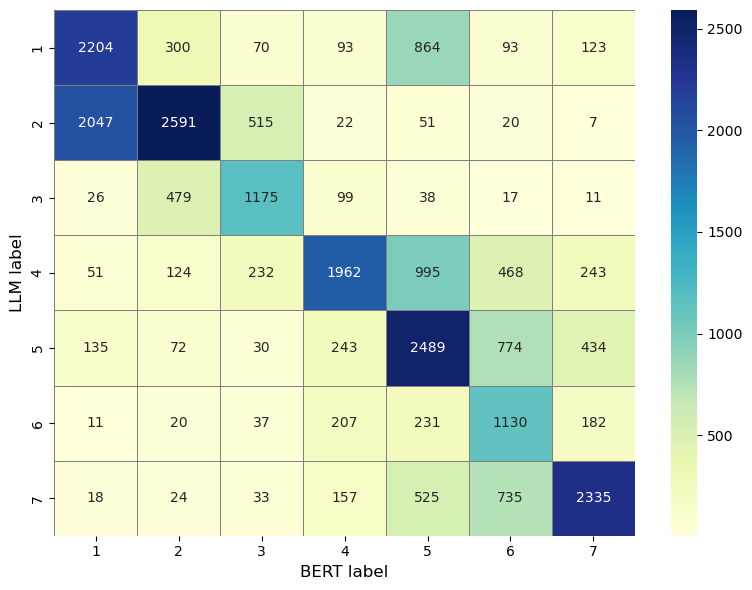

In [114]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='YlGnBu', linewidths=0.5, linecolor='gray')
# plt.title('Confusion Matrix: NAED (Mapped) vs. Hierarchical Clusters', fontsize=14)
plt.xlabel('BERT label', fontsize=12)
plt.ylabel('LLM label', fontsize=12)
plt.tight_layout()
plt.savefig('../images/conf_matrix_LLM_BERT.png')
plt.show()


## Metrics Analysis

In [113]:
y_true = df['naed_label']
y_pred = df['hier_label']

report = classification_report(y_true, y_pred)
print(report)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

                                    precision    recall  f1-score   support

Breakfast Bakes, Breads & Pancakes       0.49      0.59      0.54      3747
         Desserts, Cookies & Cakes       0.72      0.49      0.58      5253
    Drinks, Punches & Fruit Treats       0.56      0.64      0.60      1845
                 Meat & Fish Mains       0.70      0.61      0.65      3827
Pasta & Vegetable Casseroles/Bakes       0.48      0.60      0.53      4177
   Salads, Slaws, Dips & Dressings       0.70      0.48      0.57      4075
           Soups, Stews & One-Pots       0.35      0.62      0.45      1818

                          accuracy                           0.56     24742
                         macro avg       0.57      0.58      0.56     24742
                      weighted avg       0.60      0.56      0.57     24742

Accuracy: 0.56
Precision: 0.57
Recall: 0.58
